# Configuration file creation

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [ ]:
#
def makedatasetPos(data):
  dataset=[]
  label=[]
  for i in range(len(data)):
    for j in range(i+1,len(data)):
      dataset.append(np.concatenate((data[i],data[j]), axis=None))
      label.append(1)
      #dataset.append(np.concatenate((data[j],data[i]), axis=None))
      #label.append(1)
  return(dataset,label)

In [ ]:

def makedatasetNeg(data1,data2):
  dataset=[]
  label=[]
  for i in range(len(data1)):
    for j in range(len(data2)):
      dataset.append(np.concatenate((data1[i],data2[j]), axis=None))
      label.append(0)
      #dataset.append(np.concatenate((data2[j],data1[i]), axis=None))
      #label.append(0)
  return(dataset,label)

In [ ]:
def InternalTest(x1_test,x0_test):
  dataset_test2=[]    #concat test
  label_test2=[]
  for i in range(len(x0_test)):
    for j in range(i+1,len(x0_test)):
      dataset_test2.append(np.concatenate((x0_test[i],x0_test[j]), axis=None))
      label_test2.append(1)

  for i in range(len(x1_test)):
    for j in range(i+1,len(x1_test)):
      dataset_test2.append(np.concatenate((x1_test[i],x1_test[j]), axis=None))
      label_test2.append(1)

  for i in range(len(x0_test)):
    for j in range(len(x1_test)):
      dataset_test2.append(np.concatenate((x0_test[i],x1_test[j]), axis=None))
      label_test2.append(0)
  return(np.asarray(dataset_test2),np.asarray(label_test2))


In [ ]:
def MakeDatasetforTrain(P1,P0,N,LP1,LP0,LN):
  TempP0=[]
  TempL0=[]
  i=0
  while(i<len(P1)):
    l=random.randint(0,len(P0)-1)
    TempP0.append(P0[l])
    TempL0.append(LP0[l])
    i=i+1
  print('P1',len(P1), 'P0', len(TempP0))
  train=np.copy(np.append(P1,TempP0,axis=0))
  label=np.copy(np.append(LP1,TempL0))

  TempN=[]
  TempLN=[]
  while(len(TempN)<len(train)):
    l=random.randint(0,len(N)-1)
    TempN.append(N[l])
    TempLN.append(LN[l])

  train=np.copy(np.append(train,TempN,axis=0))
  label=np.copy(np.append(label,TempLN))

  return(train,label)


In [ ]:
def ExternalTest(x0_test,x1_test,x0_train,x1_train):
  dataset_test1=[] # concat train
  label_test1=[]
  Indexsample=[]
  for i in range(len(x0_test)):
    for j in range(len(x0_train)):
      dataset_test1.append(np.concatenate((x0_test[i],x0_train[j]), axis=None))
      label_test1.append(1)
      Indexsample.append(str(i)+",0,0")   #index in test,x0_test,x0_train
  for i in range(len(x0_test)):
    for j in range(len(x1_train)):
      dataset_test1.append(np.concatenate((x0_test[i],x1_train[j]), axis=None))
      label_test1.append(0)
      Indexsample.append(str(i)+",0,1")   #index in test,x0_test,x1_train
  for i in range(len(x1_test)):
    for j in range(len(x0_train)):
      dataset_test1.append(np.concatenate((x1_test[i],x0_train[j]), axis=None))
      label_test1.append(0)
      Indexsample.append(str(i)+",1,0")  #index in test,x1_test,x0_train
  for i in range(len(x1_test)):
    for j in range(len(x1_train)):
      dataset_test1.append(np.concatenate((x1_test[i],x1_train[j]), axis=None))
      label_test1.append(1)
      Indexsample.append(str(i)+",1,1")  #index in test,x1_test,x1_train
  return(np.asarray(dataset_test1),np.asarray(label_test1),Indexsample)

In [ ]:
def DefineTest2(x0_test,x1_test,Indexsample,y_pred):
  Pred=[]
  Label=[]
  for i in range(len(x0_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0
    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #intdex test
        if int(triplet[1])==0: #type test
          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1
          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1
    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(0)

  for i in range(len(x1_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0
    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #intdex test
        if int(triplet[1])==1: #type test
          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1
          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1
    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(1)
  return(Pred,Label)


## OPD Prediction


In [ ]:
def RealTest(X,x0_train,x1_train):
  dataset_test=[] # concat train
  Indexsample=[]
  for i in range(len(X)):
    for j in range(len(x0_train)):
      dataset_test.append(np.concatenate((X[i],x0_train[j]), axis=None))
      Indexsample.append(str(i)+",0")   #index in test,x0_test,x0_train
  for i in range(len(X)):
    for j in range(len(x1_train)):
      dataset_test.append(np.concatenate((X[i],x1_train[j]), axis=None))
      Indexsample.append(str(i)+",1")   #index in test,x0_test,x1_train
  return(np.asarray(dataset_test),Indexsample)


In [ ]:
def RealPredict1(X,test_pred,Indexsample):
  Pred=[]
  for i in range(len(X)):
    cnt0Pred=0
    cnt1Pred=0

    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0

      if int(triplet[0])==i: #intdex test
          if int(triplet[1])==1: #type train
            if test_pred[j]>=0.5: #type prediction
              cnt1Pred=cnt1Pred+1
            else:
              cnt0Pred=cnt0Pred+1
          if int(triplet[1])==0: #type train
            if test_pred[j]>=0.5: #type prediction
              cnt0Pred=cnt0Pred+1
            else:
              cnt1Pred=cnt1Pred+1

    if cnt0Pred>cnt1Pred:
      Pred.append(cnt0Pred)
    else:
      Pred.append(cnt1Pred)
  return(Pred)


In [ ]:

def Accuracy(label_test, pred):

  print('AUC: ', metrics.roc_auc_score(label_test, pred), 'AUPR: ', metrics.average_precision_score(label_test, pred))
  for i  in range(len(pred)):
    if pred[i]>=0.5:
      pred[i]=1
    else:
      pred[i]=0
  tn, fp, fn, tp = confusion_matrix(label_test, pred).ravel()
  specificity = tn / (tn+fp)
  sensitivity = tp / (tp + fn)
  print('ACC:',metrics.accuracy_score(label_test, pred)*100,'Spc:',specificity,'Sen: ', sensitivity,'TN:',tn, 'FP: ', fp, 'FN',fn, 'TP',tp)


In [ ]:


def SelectName(Pred,cutoff):
  # dir3='/content/drive/MyDrive/ThesisStudent/Osta/21-4-1402/Abbass/After_Abbass_death/'
  # f=open(dir3+'pep_name.txt')
  f = open('/content/drive/MyDrive/Osta/21-4-1402/Abbass/After_Abbass_death/pep_name.txt')
  i=0
  dic1={}
  for line in f:
        line=line.strip()
        if Pred[i]>=cutoff:
          dic1[line]=Pred[i]
          print(line , Pred[i])
        i=i+1
  f.close()

# Data

## Uploading OPs and Non-OPs

In [ ]:
# vec_pos: the ProtBert-Based of OPs collected from OP-AND

df_pos = pd.read_csv('vec_pos.txt', sep="\t", header=None)


In [ ]:
# vec_neg_Q5T9C2: the ProtBert-Based of NPP collected from Q5T9C2

df_neg1 = pd.read_csv('vec_neg_Q5T9C2.txt', sep=",", header=None)

In [ ]:
# vec_neg_Q5T9C2: the ProtBert-Based of NPP collected from Q9CWT3

df_neg2 = pd.read_csv('vec_neg_Q9CWT3.txt', sep=",", header=None)

In [ ]:
# vec_neg_O88942: the ProtBert-Based of NPP collected from O88942

df_neg3 = pd.read_csv('/content/drive/MyDrive/Osta/21-4-1402/negative_O88942_bonloss_Embed.txt', sep=",", header=None)



In [ ]:
# merging all neg data of bone loss proteins

df_neg = pd.concat([df_neg1, df_neg2, df_neg3], ignore_index=True)

(45, 1024)

## Balanced training dataset construction

In [ ]:
X1 = df_pos.to_numpy(dtype='float')
X0 = df_neg.to_numpy(dtype='float')

In [ ]:

Y1 = [1 for i in range(X1.shape[0])]
Y0 = [0 for i in range(X0.shape[0])]

In [ ]:
x0_train,x0_test,y0_train,y0_test=train_test_split(X0,Y0,test_size=0.2,shuffle=True)
x1_train,x1_test,y1_train,y1_test=train_test_split(X1,Y1,test_size=0.2,shuffle=True)
del X0
del Y0
del X1
del Y1

In [ ]:
dataset1p,label1p=makedatasetPos(x1_train)
dataset0p,label0p=makedatasetPos(x0_train)
datasetn,labeln=makedatasetNeg(x0_train,x1_train)
main_train1p=np.asarray(dataset1p)
main_train0p=np.asarray(dataset0p)
main_trainn=np.asarray(datasetn)
main_labeln=np.asarray(labeln)
main_label1p=np.asarray(label1p)
main_label0p=np.asarray(label0p)

del dataset1p
del dataset0p
del datasetn
del labeln
del label1p
del label0p

# SimPep framework

## SimPep-Net

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


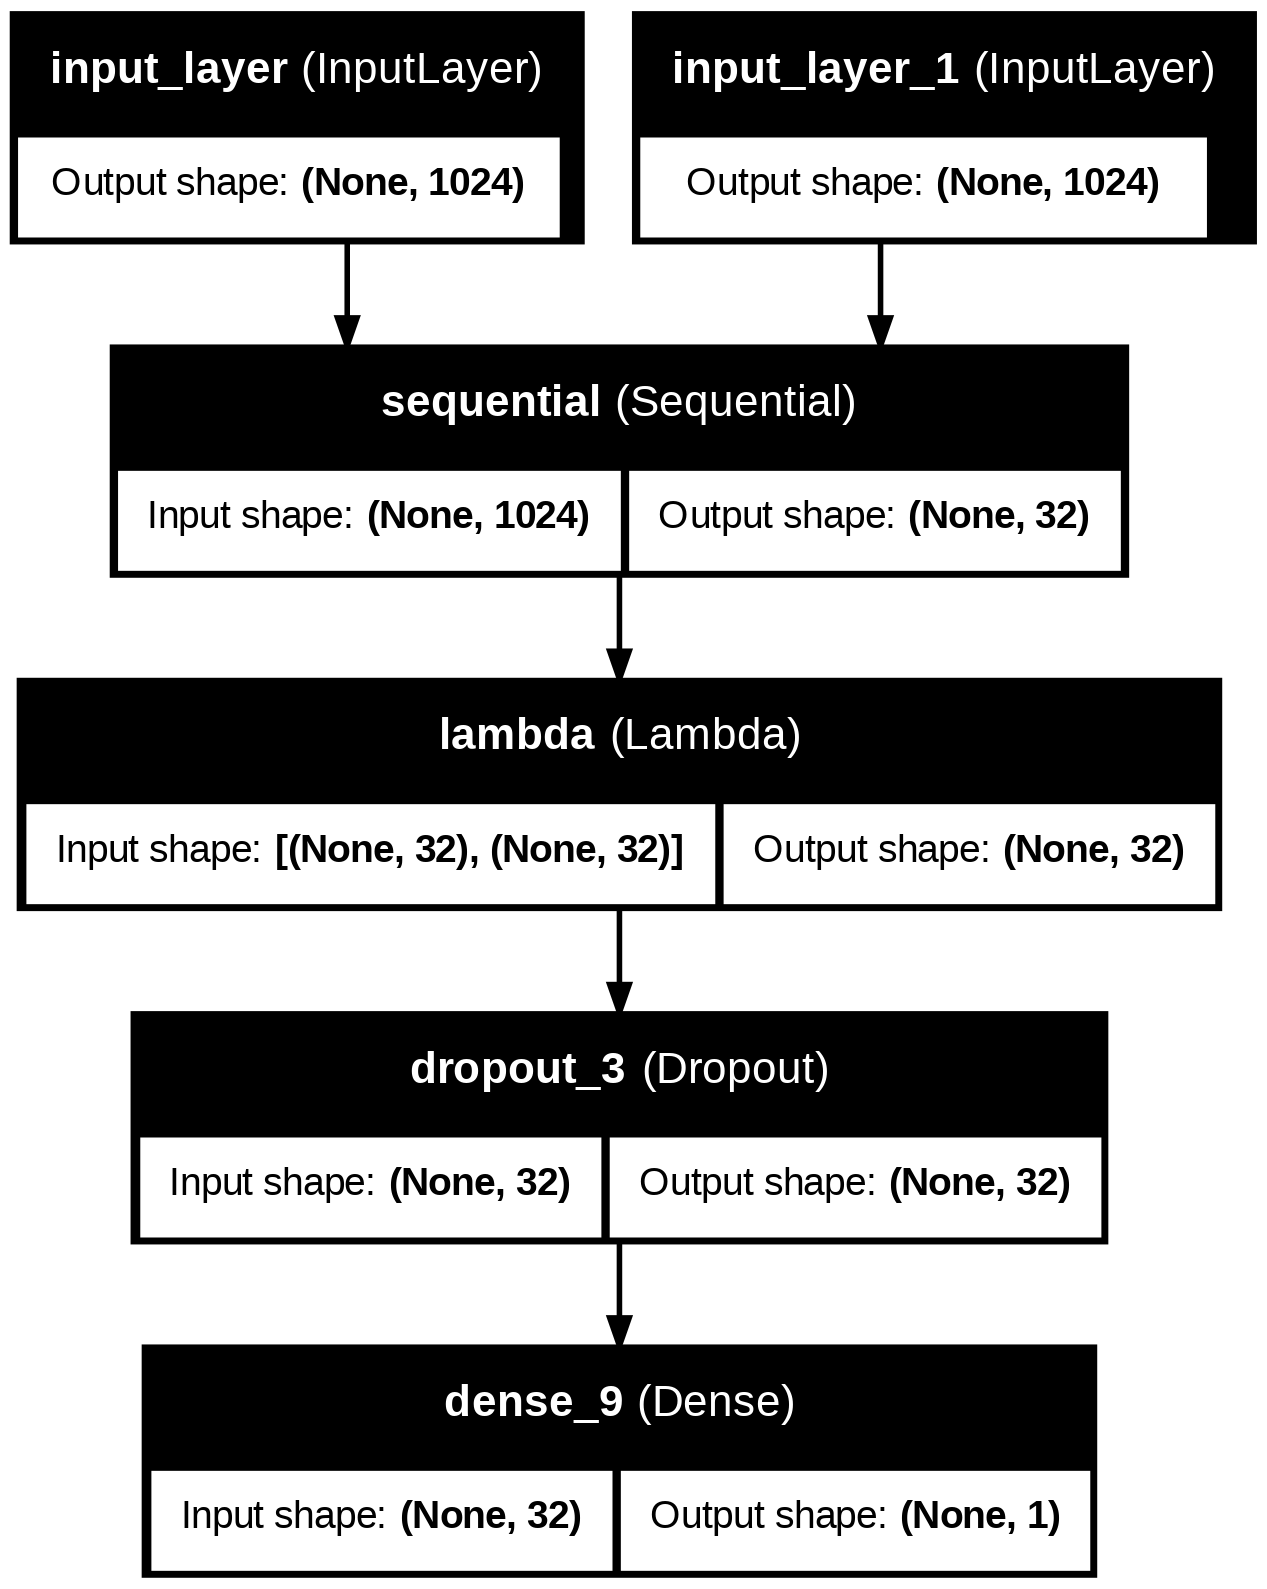

In [ ]:
input_shape1=(len(x0_train[0]),)
left_input = Input(shape=(len(x0_train[0]),))
right_input = Input(shape=(len(x0_train[0]),))


hidden_size11=512
hidden_size12=128
hidden_size13=64
hidden_size14=32





model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_size11,input_shape=input_shape1,  activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(hidden_size12, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(hidden_size13, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(hidden_size14, activation='relu'),
])


encoded_l = model(left_input)
encoded_r = model(right_input)

L1 = tf.keras.layers.Lambda (lambda x: K.abs(x[0]-x[1]))([encoded_l, encoded_r])
L1_D=tf.keras.layers.Dropout(0.2)(L1)
L2 = tf.keras.layers.Dense(16, activation='relu')(L1_D)
L2_D=tf.keras.layers.Dropout(0.2)(L2)
L3 = tf.keras.layers.Dense(16, activation='relu')(L2_D)
L3_D=tf.keras.layers.Dropout(0.2)(L3)
L4 = tf.keras.layers.Dense(16, activation='relu')(L3_D)
L4_D=tf.keras.layers.Dropout(0.2)(L4)
L5 = tf.keras.layers.Dense(8, activation='relu')(L4_D)
L5_D=tf.keras.layers.Dropout(0.2)(L5)
L6 = tf.keras.layers.Dense(1, activation='relu')(L1_D)

prediction = tf.keras.layers.Dense(1, activation='sigmoid')(L1_D)


siamese_net = tf.keras.Model([left_input, right_input], prediction)

optimizer= Adam(learning_rate=0.0001)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", "mae", "mse"])

optimizer = Adam(learning_rate = 0.0001)
model.compile(loss="kl_divergence",optimizer=optimizer)



plot_model(siamese_net, show_shapes=True, show_layer_names=True)
#siamese_net.summary()

## Training optimization

In [ ]:
from tensorflow.keras.callbacks import  History
Epoch=5
history=History()
train,label=MakeDatasetforTrain(main_train1p,main_train0p,main_trainn,main_label1p,main_label0p,main_labeln)
main_trainL1=np.array(train[:,0:int(len(train[0])/2)])
main_trainR1=np.array(train[:,int(len(train[0])/2):len(train[0])])
main_label1=np.array(label)
count1 = np.count_nonzero(main_label1 == 1)
count0 = np.count_nonzero(main_label1 == 0)
print(count1 , count0)

P = siamese_net.fit([main_trainL1, main_trainR1],main_label1, epochs= Epoch,batch_size=128, callbacks=history)
for j in range(1000):
  C=1
  Before=int(P.history['accuracy'][-1]*100)
  for i in range(2,Epoch+1):
    if  int(P.history['accuracy'][-i]*100)==Before:
      C=C+1
    else:
      C=1
    Before=int(P.history['accuracy'][-i]*100)
    print(Before)
  if C==5:
    break

  train,label=MakeDatasetforTrain(main_train1p,main_train0p,main_trainn,main_label1p,main_label0p,main_labeln)
  main_trainL1=np.array(train[:,0:int(len(train[0])/2)])
  main_trainR1=np.array(train[:,int(len(train[0])/2):len(train[0])])
  main_label1=np.array(label)
  P = siamese_net.fit([main_trainL1, main_trainR1], main_label1,batch_size=128, epochs=Epoch, callbacks=history)
  print(j+1)

P1 2016 P0 2016
4032 4032
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5814 - loss: 0.0000e+00 - mae: 0.4912 - mse: 0.2431
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6264 - loss: 0.0000e+00 - mae: 0.4772 - mse: 0.2333
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6749 - loss: 0.0000e+00 - mae: 0.4576 - mse: 0.2217
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7162 - loss: 0.0000e+00 - mae: 0.4265 - mse: 0.2025
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7624 - loss: 0.0000e+00 - mae: 0.3946 - mse: 0.1829
72
68
63
58
P1 2016 P0 2016
8064
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7973 - loss: 0.0000e+00 - mae: 0.3615 - mse: 0.1641
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8355 - loss: 0.0000e+00 - mae: 0.3223 - mse: 0.1391
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8701 - loss: 0.0000e+00 - mae: 0.2761 - mse: 0.1140
Epoch 4/5
63/

In [ ]:
# removing unnecceasary variables to reduce the RAM usage
del df_neg, df_pos, main_train0p, main_label1, main_label0p, main_label1p, main_trainL1, main_trainR1, main_train1p

## SimPep-Net validation

In [ ]:
main_test2,main_label_test2=InternalTest(x1_test,x0_test)
y_pred=siamese_net.predict([np.array(main_test2[:,0:int(len(main_test2[0])/2)]),np.array(main_test2[:,int(len(main_test2[0])/2):len(main_test2[0])])])
Accuracy(main_label_test2, y_pred)
del main_test2,main_label_test2, y_pred


## OPD Prediction

In [ ]:
main_test1,main_label_test1,Indexsample=ExternalTest(x0_test,x1_test,x0_train,x1_train)
y_pred=siamese_net.predict([np.array(main_test1[:,0:int(len(main_test1[0])/2)]),np.array(main_test1[:,int(len(main_test1[0])/2):len(main_test1[0])])])
Pred,Label=DefineTest2(x0_test,x1_test,Indexsample,y_pred)
del main_test1,main_label_test1,Indexsample
Accuracy(Label, Pred)
del Label, Pred

AUC:  0.7361990950226245 AUPR:  0.47007176143145624
ACC: 91.15646258503402 Spc: 0.9769230769230769 Sen:  0.4117647058823529 TN: 127 FP:  3 FN 10 TP 7


In [ ]:
## Checking for case study
df_test = pd.read_csv('vec_case_study.txt', sep="\t", header=None)
X=np.asarray(df_test)



In [ ]:
main_test,IndexsampleTest=RealTest(X,x0_train,x1_train)
main_tesxLX=np.array(main_test[:,0:int(len(main_test[0])/2)])
main_testRX=np.array(main_test[:,int(len(main_test[0])/2):len(main_test[0])])
y_pred=siamese_net.predict([main_tesxLX,main_testRX])
y_pred=RealPredict(X,y_pred,IndexsampleTest)
SelectName(y_pred,0.8)

>camel-beta-peptide 5 [0.8872845]
>bovin-beta-peptide 7 [0.86403257]
>human-beta-peptide 3 [0.87967134]
>human-kappa-peptide 11 [0.90156937]


In [ ]:
del y_pred, X, main_tesxLX,main_testRX

In [ ]:
del IndexsampleTest, history, label, main_trainn



# External test sets


In [ ]:
# Experminetal_negative_vec: the ProtBert-based vector of experimental negative data

df_test2 = pd.read_csv('Experminetal_negative_vec.txt', header=None)

X_new_neg = np.asarray(df_test2)


In [ ]:
main_test,IndexsampleTest=RealTest(X_new_neg,x0_train,x1_train)
main_tesxLX=np.array(main_test[:,0:int(len(main_test[0])/2)])
main_testRX=np.array(main_test[:,int(len(main_test[0])/2):len(main_test[0])])
y_pred=siamese_net.predict([main_tesxLX,main_testRX])
y_pred=RealPredict(X_new_neg,y_pred,IndexsampleTest)
y_pred

[array([0.22340016], dtype=float32),
 array([0.13297284], dtype=float32),
 array([0.10937601], dtype=float32),
 array([0.88242143], dtype=float32)]

In [ ]:
# new_OP_vec: the ProtBert-based vector of Ops from 2022 to 2024
# For this assessment, the model should be trained first without this data

df_test = pd.read_csv('new_OP_vec.txt', sep="\t", header=None)
X_new_pos=np.asarray(df_test)

In [ ]:
main_test,IndexsampleTest=RealTest(X_new_pos,x0_train,x1_train)
main_tesxLX=np.array(main_test[:,0:int(len(main_test[0])/2)])
main_testRX=np.array(main_test[:,int(len(main_test[0])/2):len(main_test[0])])

In [ ]:
y_pred=siamese_net.predict([main_tesxLX,main_testRX])
y_pred=RealPredict(X_new_pos,y_pred,IndexsampleTest)
y_pred

[array([0.93163073], dtype=float32),
 array([0.2837767], dtype=float32),
 array([0.17874585], dtype=float32),
 array([0.16910979], dtype=float32),
 array([0.17543823], dtype=float32),
 array([0.15224825], dtype=float32),
 array([0.1593636], dtype=float32),
 array([0.85469], dtype=float32),
 array([0.89563197], dtype=float32),
 array([0.87257445], dtype=float32),
 array([0.8969664], dtype=float32),
 array([0.9104396], dtype=float32),
 array([0.9180465], dtype=float32),
 array([0.12953553], dtype=float32),
 array([0.86453176], dtype=float32),
 array([0.18906485], dtype=float32),
 array([0.18737742], dtype=float32),
 array([0.17875192], dtype=float32),
 array([0.5052275], dtype=float32),
 array([0.20020354], dtype=float32),
 array([0.2154391], dtype=float32),
 array([0.16753079], dtype=float32),
 array([0.50195324], dtype=float32),
 array([0.27825797], dtype=float32),
 array([0.18382709], dtype=float32),
 array([0.15432584], dtype=float32),
 array([0.16753079], dtype=float32)]